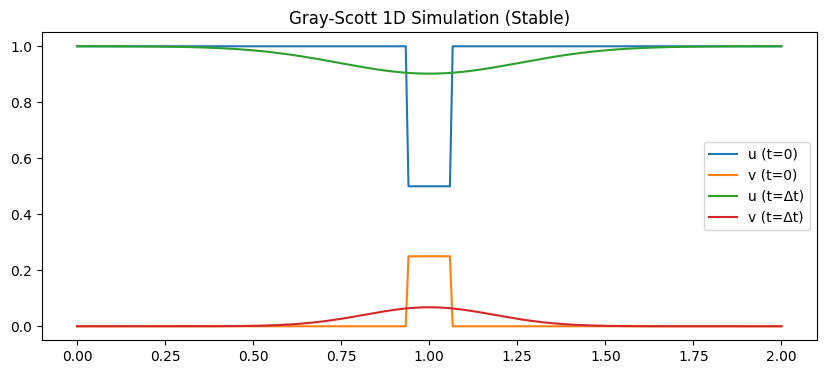

In [163]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gray_scott(Nx=256, L=2.0, Du=0.16, Dv=0.08, F=0.035, k=0.065, dt=2e-5, steps=10000):
    dx = L / Nx
    x = np.linspace(0, L, Nx)
    u = np.ones(Nx)
    v = np.zeros(Nx)
    u[Nx//2-8:Nx//2+8] = 0.5
    v[Nx//2-8:Nx//2+8] = 0.25

    us = [u.copy()]
    vs = [v.copy()]

    for i in range(steps):
        laplace_u = (np.roll(u, -1) + np.roll(u, 1) - 2*u) / dx**2
        laplace_v = (np.roll(v, -1) + np.roll(v, 1) - 2*v) / dx**2

        uvv = u * v * v
        du = Du * laplace_u - uvv + F*(1-u)
        dv = Dv * laplace_v + uvv - (F+k)*v

        u += dt * du
        v += dt * dv

        # Clip to physically valid values
        u = np.clip(u, 0, 1.5)
        v = np.clip(v, 0, 1.5)

        if (i+1) % 100 == 0:
            us.append(u.copy())
            vs.append(v.copy())

    return x, np.array(us), np.array(vs)

# Generate data
Nx = 256
x, us, vs = simulate_gray_scott(Nx=Nx, dt=2e-5, steps=10000)

plt.figure(figsize=(10,4))
plt.plot(x, us[0], label='u (t=0)')
plt.plot(x, vs[0], label='v (t=0)')
plt.plot(x, us[-1], label='u (t=Δt)')
plt.plot(x, vs[-1], label='v (t=Δt)')
plt.legend()
plt.title("Gray-Scott 1D Simulation (Stable)")
plt.show()

In [164]:
import torch
import torch.nn as nn

class DeepONet1D(nn.Module):
    def __init__(self, Nx):
        super().__init__()
        self.Nx = Nx
        # [u0, v0] input: shape (2*Nx,)
        self.branch = nn.Sequential(
            nn.Linear(2*Nx, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2*Nx),
        )
        # Δt input: (1,)
        self.trunk = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2*Nx),
        )

    def forward(self, u0v0, dt):
        # u0v0: (batch, 2*Nx), dt: (batch, 1)
        branch_out = self.branch(u0v0)      # (batch, 2*Nx)
        trunk_out = self.trunk(dt)          # (batch, 2*Nx)
        out = branch_out + trunk_out        # (batch, 2*Nx)
        return out.reshape(-1, 2, self.Nx)  # (batch, 2, Nx)

In [165]:
def gray_scott_residual(u, v, Du, Dv, F, k, dx):
    # u, v: (batch, Nx) torch tensors
    u_pad = torch.cat([u[:, -1:], u, u[:, :1]], dim=1)
    v_pad = torch.cat([v[:, -1:], v, v[:, :1]], dim=1)
    lap_u = (u_pad[:, 2:] + u_pad[:, :-2] - 2 * u) / dx ** 2
    lap_v = (v_pad[:, 2:] + v_pad[:, :-2] - 2 * v) / dx ** 2

    uvv = u * v * v
    du_dt = Du * lap_u - uvv + F * (1 - u)
    dv_dt = Dv * lap_v + uvv - (F + k) * v
    return du_dt, dv_dt

In [166]:
def smoothing_loss(u_pred, v_pred):
    # u_pred, v_pred: (batch, Nx)
    return ((u_pred[:, 1:] - u_pred[:, :-1])**2).mean() + \
           ((v_pred[:, 1:] - v_pred[:, :-1])**2).mean()

In [167]:
def train_deeponet_pinno(
    model, optimizer, 
    x, us, vs, 
    Du, Dv, F, k, dt, Δt_idx,
    epochs=1000, device='cpu', λ_smooth=1e-3, λ_phy=1e-3, λ_ic=1e-3
):
    Nx = x.shape[0]
    dx = x[1] - x[0]

    # Prepare tensors for initial condition input
    u0v0 = np.stack([us[0], vs[0]], axis=0).reshape(-1)  # (2*Nx,)
    dt_in = np.array([[Δt_idx * dt]], dtype=np.float32)  # (1,1)
    u0v0_tensor = torch.tensor(u0v0, dtype=torch.float32, device=device).unsqueeze(0)
    dt_tensor = torch.tensor(dt_in, dtype=torch.float32, device=device)  # (1,1)

    # Targets for plotting only, not for training
    u_target = torch.tensor(us[Δt_idx], dtype=torch.float32, device=device).unsqueeze(0)
    v_target = torch.tensor(vs[Δt_idx], dtype=torch.float32, device=device).unsqueeze(0)

    model.to(device)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        # forward
        pred = model(u0v0_tensor, dt_tensor)         # (1, 2, Nx)
        u_pred = pred[:, 0, :]
        v_pred = pred[:, 1, :]

        # Physics residual loss
        du_dt, dv_dt = gray_scott_residual(
            u_pred, v_pred, Du, Dv, F, k, dx
        )
        physics_loss = (du_dt**2).mean() + (dv_dt**2).mean()

        # Initial condition loss at t=0
        u0 = torch.tensor(us[0], dtype=torch.float32, device=device).unsqueeze(0)
        v0 = torch.tensor(vs[0], dtype=torch.float32, device=device).unsqueeze(0)
        ic_loss = ((u_pred - u0)**2).mean() + ((v_pred - v0)**2).mean()

        # Smoothing loss
        smooth_loss = smoothing_loss(u_pred, v_pred)
        switch_epoch = 100

        if epoch < switch_epoch: 
            wt_phy = 0.0
            wt_smooth = 0.0
        else:
            wt_phy = λ_phy * (epoch - switch_epoch) / (epochs - switch_epoch)
            wt_smooth = λ_smooth * (epoch - switch_epoch) / (epochs - switch_epoch)

        loss = ic_loss * λ_ic + wt_phy * physics_loss + wt_smooth * smooth_loss
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if epoch % 500 == 0 or epoch == epochs-1:
            print(
                f"Epoch {epoch}: Total={loss.item():.6f} | "
                f"IC={ic_loss.item():.6f} | Physics={physics_loss.item():.6f} "
                f" | Smooth={smooth_loss.item():.6f}"
            )

    return model, losses, (u_pred.cpu().detach().numpy(), v_pred.cpu().detach().numpy()), (u_target.cpu().numpy(), v_target.cpu().numpy())

Epoch 0: Total=0.987765 | IC=0.987765 | Physics=363606.500000  | Smooth=0.031809
Epoch 500: Total=1.295411 | IC=0.733848 | Physics=82.830460  | Smooth=0.000010
Epoch 1000: Total=0.919571 | IC=0.737278 | Physics=11.950314  | Smooth=0.000004
Epoch 1500: Total=0.793364 | IC=0.748646 | Physics=1.884550  | Smooth=0.000002
Epoch 2000: Total=0.757395 | IC=0.752785 | Physics=0.143146  | Smooth=0.000002
Epoch 2500: Total=1.748270 | IC=0.755898 | Physics=24.395809  | Smooth=0.000003
Epoch 3000: Total=0.826602 | IC=0.758423 | Physics=1.387091  | Smooth=0.000001
Epoch 3500: Total=0.770293 | IC=0.764644 | Physics=0.098027  | Smooth=0.000001
Epoch 4000: Total=0.779386 | IC=0.768450 | Physics=0.165442  | Smooth=0.000001
Epoch 4500: Total=0.846715 | IC=0.769117 | Physics=1.040515  | Smooth=0.000001
Epoch 5000: Total=0.774830 | IC=0.771478 | Physics=0.040362  | Smooth=0.000001
Epoch 5500: Total=0.779742 | IC=0.778043 | Physics=0.018561  | Smooth=0.000001
Epoch 5999: Total=0.859302 | IC=0.778071 | Physi

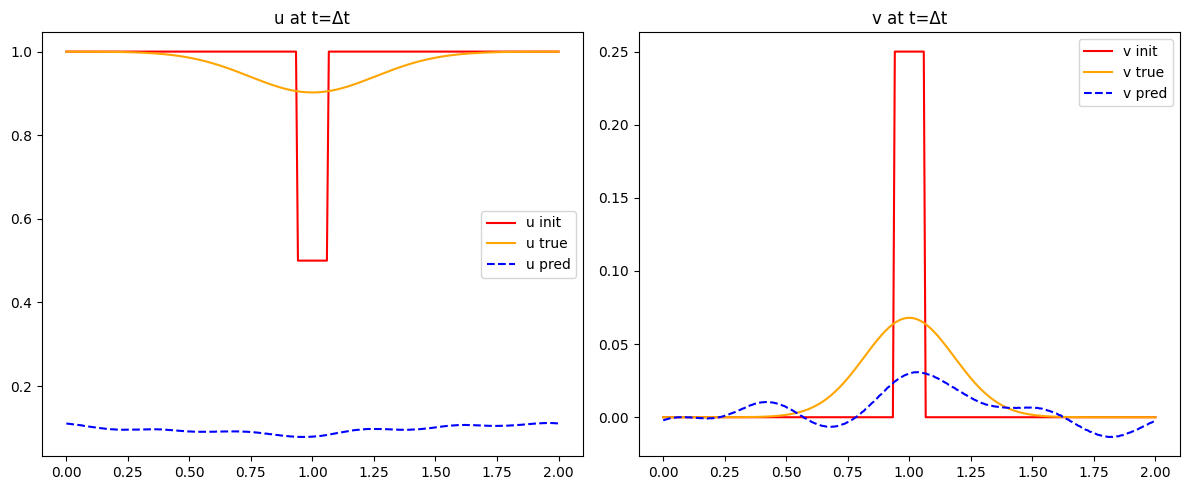

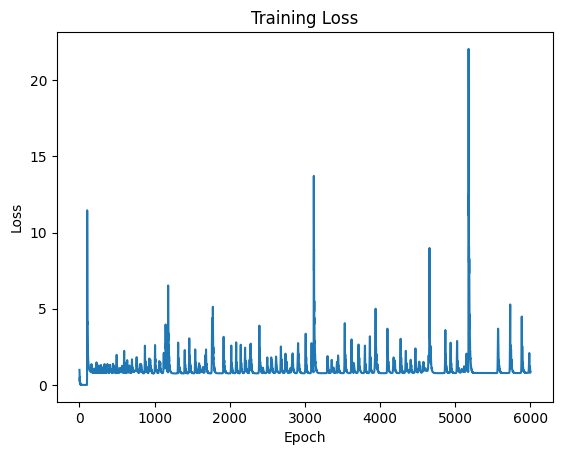

In [168]:
import torch.optim as optim

# Settings (should match simulation)
Du, Dv, F, k = 0.16, 0.08, 0.035, 0.065
dt = 1e-3
Δt_idx = -1 # last time point as Δt

# Prepare and train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DeepONet1D(Nx=Nx)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model, losses, (u_pred, v_pred), (u_target, v_target) = train_deeponet_pinno(
    model, optimizer,
    x, us, vs,
    Du, Dv, F, k, dt, Δt_idx,
    epochs=6000,
    device=device,
    λ_ic = 1,
    λ_smooth=1e-2,
    λ_phy=1e-1
)

# Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x, us[0], label='u init', color='red')
plt.plot(x, u_target[0], label='u true', color='orange')
plt.plot(x, u_pred[0], '--', label='u pred', color='blue')
plt.legend()
plt.title("u at t=Δt")

plt.subplot(1,2,2)
plt.plot(x, vs[0], label='v init', color='red')
plt.plot(x, v_target[0], label='v true', color='orange')
plt.plot(x, v_pred[0], '--', label='v pred', color='blue')
plt.legend()
plt.title("v at t=Δt")

plt.tight_layout()
plt.show()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()
